In [11]:
pip install torch torchvision segmentation-models-pytorch albumentations opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
# ----------------------------
# Dataset
# ----------------------------
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Grayscale image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # Convert to tensor, add channel dimension
        image = torch.tensor(image[np.newaxis, ...]).float() / 255.0
        mask = torch.tensor(mask).long()
        return image, mask

In [14]:
# ----------------------------
# Training Config
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 8
N_CLASSES = 2   # adjust if needed (binary or multi-class)

In [15]:
# ----------------------------
# Model
# ----------------------------
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=1, classes=N_CLASSES).to(DEVICE)

weights = torch.tensor([0.2, 0.8]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [16]:
# Dice Loss (recommended for binary segmentation):
def dice_loss(pred, target, smooth=1.0):
    pred = torch.softmax(pred, dim=1)[:,1,...]  # take foreground channel
    target = target.float()
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [17]:
# ----------------------------
# Data Loaders
# ----------------------------
from albumentations import Compose, Resize

train_transform = Compose([Resize(25, 25)])
train_ds = SegmentationDataset("src/dataset_aug/images", "src/dataset_aug/binary_masks", transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
# ----------------------------
# Training Loop
# ----------------------------
epoch_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)

        # Combined loss
        loss = 0.5 * criterion(preds, masks) + 0.5 * dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "seg_model.pth")

Epoch 1/100: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 1, Loss: 1.0593


Epoch 2/100: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Epoch 2, Loss: 0.9963


Epoch 3/100: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


Epoch 3, Loss: 0.9221


Epoch 4/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 4, Loss: 0.8739


Epoch 5/100: 100%|██████████| 12/12 [00:02<00:00,  4.58it/s]


Epoch 5, Loss: 0.8258


Epoch 6/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 6, Loss: 0.7872


Epoch 7/100: 100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


Epoch 7, Loss: 0.7582


Epoch 8/100: 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


Epoch 8, Loss: 0.7306


Epoch 9/100: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 9, Loss: 0.7100


Epoch 10/100: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]


Epoch 10, Loss: 0.6943


Epoch 11/100: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]


Epoch 11, Loss: 0.6784


Epoch 12/100: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 12, Loss: 0.6631


Epoch 13/100: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Epoch 13, Loss: 0.6508


Epoch 14/100: 100%|██████████| 12/12 [00:02<00:00,  4.74it/s]


Epoch 14, Loss: 0.6382


Epoch 15/100: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 15, Loss: 0.6268


Epoch 16/100: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


Epoch 16, Loss: 0.6285


Epoch 17/100: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s]


Epoch 17, Loss: 0.6168


Epoch 18/100: 100%|██████████| 12/12 [00:02<00:00,  4.57it/s]


Epoch 18, Loss: 0.6061


Epoch 19/100: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch 19, Loss: 0.6034


Epoch 20/100: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


Epoch 20, Loss: 0.5837


Epoch 21/100: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 21, Loss: 0.5743


Epoch 22/100: 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]


Epoch 22, Loss: 0.5641


Epoch 23/100: 100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


Epoch 23, Loss: 0.5601


Epoch 24/100: 100%|██████████| 12/12 [00:02<00:00,  4.80it/s]


Epoch 24, Loss: 0.5470


Epoch 25/100: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


Epoch 25, Loss: 0.5323


Epoch 26/100: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 26, Loss: 0.5280


Epoch 27/100: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]


Epoch 27, Loss: 0.5187


Epoch 28/100: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


Epoch 28, Loss: 0.5120


Epoch 29/100: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch 29, Loss: 0.5041


Epoch 30/100: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Epoch 30, Loss: 0.4992


Epoch 31/100: 100%|██████████| 12/12 [00:02<00:00,  4.85it/s]


Epoch 31, Loss: 0.4846


Epoch 32/100: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Epoch 32, Loss: 0.4808


Epoch 33/100: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]


Epoch 33, Loss: 0.4721


Epoch 34/100: 100%|██████████| 12/12 [00:02<00:00,  4.80it/s]


Epoch 34, Loss: 0.4615


Epoch 35/100: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch 35, Loss: 0.4432


Epoch 36/100: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


Epoch 36, Loss: 0.4477


Epoch 37/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 37, Loss: 0.4374


Epoch 38/100: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


Epoch 38, Loss: 0.4239


Epoch 39/100: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch 39, Loss: 0.4251


Epoch 40/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 40, Loss: 0.4046


Epoch 41/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 41, Loss: 0.4002


Epoch 42/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 42, Loss: 0.4013


Epoch 43/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 43, Loss: 0.3866


Epoch 44/100: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch 44, Loss: 0.3677


Epoch 45/100: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Epoch 45, Loss: 0.3769


Epoch 46/100: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch 46, Loss: 0.3684


Epoch 47/100: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


Epoch 47, Loss: 0.3699


Epoch 48/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 48, Loss: 0.3691


Epoch 49/100: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch 49, Loss: 0.3483


Epoch 50/100: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch 50, Loss: 0.3412


Epoch 51/100: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch 51, Loss: 0.3296


Epoch 52/100: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch 52, Loss: 0.3389


Epoch 53/100: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Epoch 53, Loss: 0.3245


Epoch 54/100: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch 54, Loss: 0.3244


Epoch 55/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 55, Loss: 0.3188


Epoch 56/100: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch 56, Loss: 0.3006


Epoch 57/100: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch 57, Loss: 0.3069


Epoch 58/100: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch 58, Loss: 0.3018


Epoch 59/100: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch 59, Loss: 0.2901


Epoch 60/100: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch 60, Loss: 0.2879


Epoch 61/100: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch 61, Loss: 0.2967


Epoch 62/100: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch 62, Loss: 0.2887


Epoch 63/100: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch 63, Loss: 0.2762


Epoch 64/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 64, Loss: 0.2722


Epoch 65/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 65, Loss: 0.2807


Epoch 66/100: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch 66, Loss: 0.2748


Epoch 67/100: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch 67, Loss: 0.2576


Epoch 68/100: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch 68, Loss: 0.2511


Epoch 69/100: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch 69, Loss: 0.2572


Epoch 70/100: 100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch 70, Loss: 0.2420


Epoch 71/100: 100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


Epoch 71, Loss: 0.2323


Epoch 72/100: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Epoch 72, Loss: 0.2564


Epoch 73/100: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch 73, Loss: 0.2235


Epoch 74/100: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Epoch 74, Loss: 0.2340


Epoch 75/100: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Epoch 75, Loss: 0.2328


Epoch 76/100: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Epoch 76, Loss: 0.2303


Epoch 77/100: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch 77, Loss: 0.2276


Epoch 78/100: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


Epoch 78, Loss: 0.2141


Epoch 79/100: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 79, Loss: 0.2319


Epoch 80/100: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch 80, Loss: 0.2024


Epoch 81/100: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch 81, Loss: 0.2205


Epoch 82/100: 100%|██████████| 12/12 [00:02<00:00,  4.51it/s]


Epoch 82, Loss: 0.2206


Epoch 83/100: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch 83, Loss: 0.2214


Epoch 84/100: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch 84, Loss: 0.2264


Epoch 85/100: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]


Epoch 85, Loss: 0.2057


Epoch 86/100: 100%|██████████| 12/12 [00:02<00:00,  4.85it/s]


Epoch 86, Loss: 0.1894


Epoch 87/100: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Epoch 87, Loss: 0.1856


Epoch 88/100: 100%|██████████| 12/12 [00:02<00:00,  4.53it/s]


Epoch 88, Loss: 0.1888


Epoch 89/100: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch 89, Loss: 0.1906


Epoch 90/100: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch 90, Loss: 0.2062


Epoch 91/100: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch 91, Loss: 0.2032


Epoch 92/100: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch 92, Loss: 0.1888


Epoch 93/100: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Epoch 93, Loss: 0.1928


Epoch 94/100: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Epoch 94, Loss: 0.1811


Epoch 95/100: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch 95, Loss: 0.1684


Epoch 96/100: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch 96, Loss: 0.1622


Epoch 97/100: 100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


Epoch 97, Loss: 0.1644


Epoch 98/100: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch 98, Loss: 0.1671


Epoch 99/100: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


Epoch 99, Loss: 0.1572


Epoch 100/100: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch 100, Loss: 0.1923


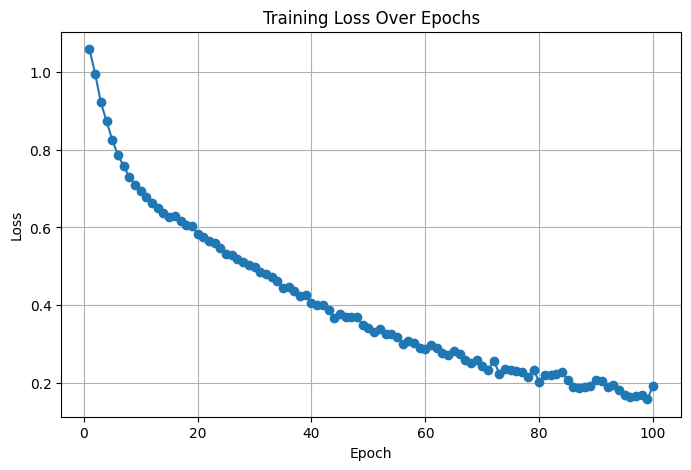

In [19]:
# ----------------------------
# Plot Loss over Epochs
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), epoch_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [20]:
# ----------------------------
# Inference on Original Images
# ----------------------------
def predict_image_any_size(model, image_path, input_size=25):
    """
    Predict a mask for any-size grayscale image using a model trained on square images.
    - image_path: path to grayscale image
    - input_size: size the model expects (training size)
    - device: 'cuda' or 'cpu'
    """
    model.eval()
    # Load original image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orig_h, orig_w = image.shape[:2]

    # Compute padding to make square
    size = max(orig_h, orig_w)
    pad_h = (size - orig_h) // 2
    pad_w = (size - orig_w) // 2

    # Pad image
    padded = np.pad(image, ((pad_h, size - orig_h - pad_h),
                            (pad_w, size - orig_w - pad_w)), mode='constant', constant_values=0)

    # Resize to model input size
    resized = cv2.resize(padded, (input_size, input_size))

    # Convert to tensor
    x = torch.tensor(resized[np.newaxis, np.newaxis, ...]).float().to(DEVICE) / 255.0

    # Model prediction
    with torch.no_grad():
        pred = model(x)
        pred_mask = torch.argmax(pred, dim=1).cpu().numpy()[0]

    # Resize back to padded size
    pred_mask = cv2.resize(pred_mask.astype(np.uint8), (size, size), interpolation=cv2.INTER_NEAREST)

    # Remove padding to restore original shape
    pred_mask = pred_mask[pad_h:pad_h+orig_h, pad_w:pad_w+orig_w]

    return pred_mask

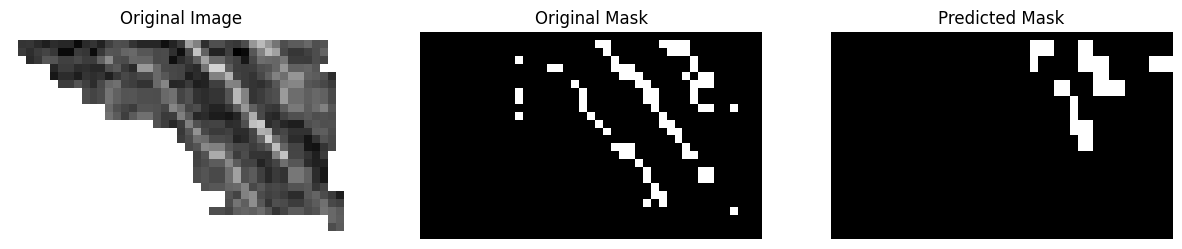

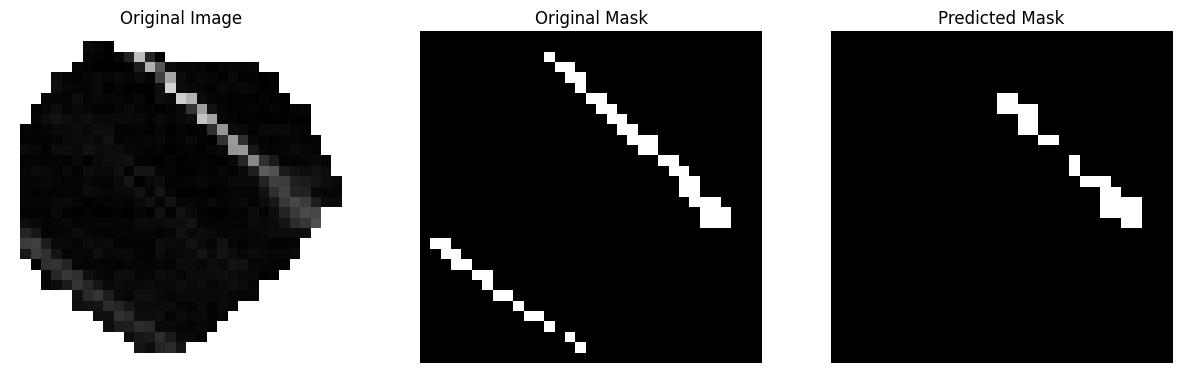

In [21]:
def show_image_mask_pred(fname):
    img_path = os.path.join("src/dataset/images/", fname + ".png")
    mask_path = os.path.join("src/dataset/masks/", fname + ".png")  # adjust if needed

    # Load original grayscale image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Load original mask (binary 0/1)
    original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    original_mask = (original_mask > 0).astype(np.uint8)

    # Predicted mask
    pred_mask = predict_image_any_size(model, img_path)

    # Plot side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(original_mask, cmap='gray')
    axes[1].set_title("Original Mask")
    axes[1].axis('off')

    axes[2].imshow(pred_mask*255, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.show()

# Usage
show_image_mask_pred("Grain 1")
show_image_mask_pred("Grain 114")

In [ ]:
from PIL import Image
import import_ipynb
import RadonAngleFinder

In [54]:
from skimage.transform import radon

def process_image(original_image, mask_image):
    mask_array = np.array(mask_image)

    # Compute Radon transform
    theta = np.linspace(0., 180, max(mask_array.shape), endpoint=False)
    sinogram = radon(mask_array, theta=theta, circle=True)
    
    plt.figure(figsize=(12, 4))  

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Model")
    plt.imshow(mask_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Radon Transform")
    plt.xlabel("Projection angle (degrees)")
    plt.imshow(sinogram, cmap='gray')
    plt.gca().set_yticks([]) 
    plt.gca().set_yticklabels([])

    plt.tight_layout()
    plt.show()

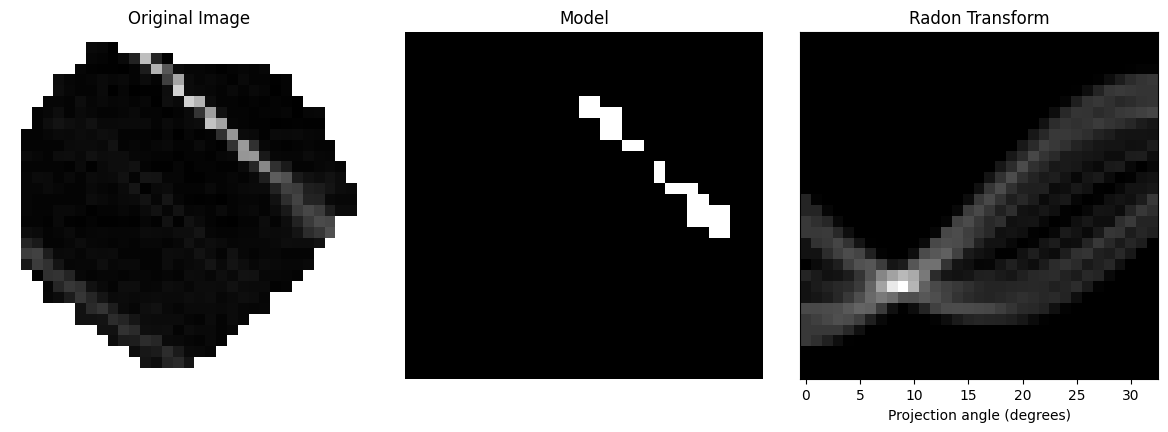

In [55]:
img_path = "src/dataset/images/Grain 114.png"
pred_mask = predict_image_any_size(model, img_path)
image = Image.open(img_path).convert("L")
process_image(image, pred_mask)